In [1]:
from sklearn.datasets import fetch_openml
from rfgap import RFGAP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from dataset import dataprep
from phate import PHATE

from sklearn.model_selection import train_test_split

In [2]:
# data = fetch_openml(name='tic-tac-toe', version=1, as_frame=True)

# x = data['data']
# y = data['target']
# y = pd.Categorical(y).codes
# x = dataprep(x, label_col_idx = None, scale = None)

In [3]:
# from ucimlrepo import fetch_ucirepo 
  
# # fetch dataset 
# adult = fetch_ucirepo(id=2) 
  
# # data (as pandas dataframes) 
# x = adult.data.features 
# y = adult.data.targets 

In [4]:
# narows = x.isna().any(axis = 1)

# x = x[narows == False]
# y = y[narows == False]  

# x[x.select_dtypes(['object']).columns] = x.select_dtypes(['object']).apply(lambda x: x.astype('category'))

# n, d = np.shape(x)

In [5]:
# x.workclass

In [6]:
# data   = pd.read_csv('../datasets/iris.csv', sep = ',')
data   = pd.read_csv('../datasets/treeData.csv', sep = ',')
x, y   = dataprep(data, scale = None)
n, d   = x.shape
n_classes = len(y.unique())

In [7]:
x_train, x_test, y_train, y_test, inds_train, inds_test = train_test_split(x, y, np.arange(n), test_size=0.1, random_state = 42)

In [8]:
rf = RFGAP(oob_score = True, non_zero_diagonal = False, random_state = 42) #non_zero_diagonal must be false
rf.fit(x, y)
prox = rf.get_proximities()

In [9]:
rf2 = RFGAP(oob_score = True, non_zero_diagonal = True, random_state = 42) #non_zero_diagonal must be false for trust
rf2.fit(x, y)
prox2 = rf2.get_proximities()

In [10]:
rf3 = RFGAP(oob_score = True, non_zero_diagonal = False, random_state = 42)
rf3.fit(x_train, y_train)
prox3 = rf3.get_proximities()

In [11]:
trust_scores = rf.get_trust_scores()

trust_scores_oob = rf3.get_trust_scores()
trust_scores_test = rf3.get_test_trust(x_test)

test_trust_scores = rf3.trust_scores_test

Currently minus not taking oob_correct into account
Currently minus not taking oob_correct into account


<Axes: ylabel='Density'>

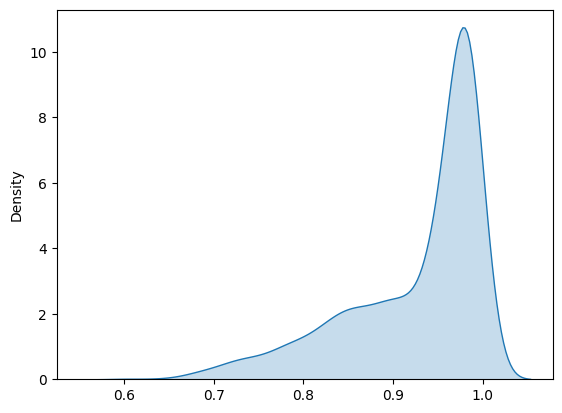

In [12]:
sns.kdeplot(trust_scores, fill = True)

In [13]:
x['trust'] = rf.trust_scores
x['class'] = y

In [14]:
def rescale(x):
    # return 100 - (x - x.min())/(x.max() - x.min()) * 100 + 5
    return 100 - x/x.max() * 100 + 5

In [15]:
phate_op = PHATE(knn_dist = 'precomputed')
emb = phate_op.fit_transform(prox2)

Calculating PHATE...
  Running PHATE on precomputed affinity matrix with 1440 observations.
  Calculating graph and diffusion operator...
  Calculated graph and diffusion operator in 0.02 seconds.
  Calculating optimal t...
    Automatically selected t = 4
  Calculated optimal t in 0.65 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.12 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 1.68 seconds.
Calculated PHATE in 2.49 seconds.


<Axes: >

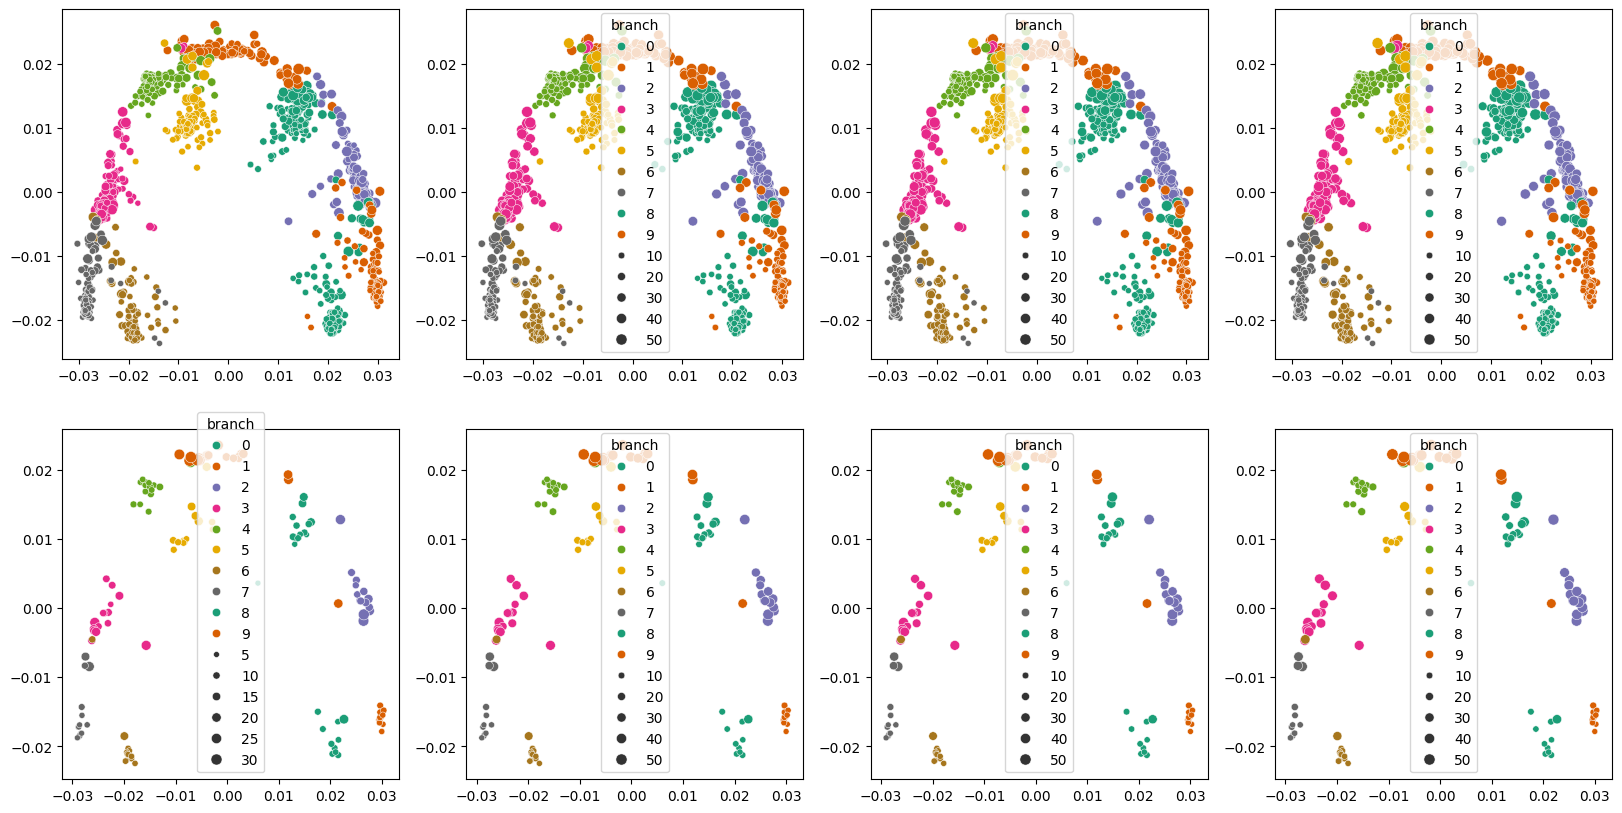

In [16]:
fig, axes = plt.subplots(2, 4, figsize = (20, 10))

sns.scatterplot(ax = axes[0, 0], x = emb[:, 0], y = emb[:, 1], hue = y, size = rescale(rf.trust_scores), palette = 'Dark2', legend = False)
sns.scatterplot(ax = axes[0, 1], x = emb[:, 0], y = emb[:, 1], hue = y, size = rescale(rf.trust_correct_proba), palette = 'Dark2')
sns.scatterplot(ax = axes[0, 2], x = emb[:, 0], y = emb[:, 1], hue = y, size = rescale(rf.trust_max_proba), palette = 'Dark2') 
sns.scatterplot(ax = axes[0, 3], x = emb[:, 0], y = emb[:, 1], hue = y, size = rescale(rf.trust_minus), palette = 'Dark2')

sns.scatterplot(ax = axes[1, 0], x = emb[inds_test, 0], y = emb[inds_test, 1], hue = y[inds_test], size = rescale(rf3.trust_scores_test), palette = 'Dark2')
sns.scatterplot(ax = axes[1, 1], x = emb[inds_test, 0], y = emb[inds_test, 1], hue = y[inds_test], size = rescale(rf3.trust_correct_proba_test), palette = 'Dark2')
sns.scatterplot(ax = axes[1, 2], x = emb[inds_test, 0], y = emb[inds_test, 1], hue = y[inds_test], size = rescale(rf3.trust_max_proba_test), palette = 'Dark2') 
sns.scatterplot(ax = axes[1, 3], x = emb[inds_test, 0], y = emb[inds_test, 1], hue = y[inds_test], size = rescale(rf3.trust_minus_test), palette = 'Dark2')

# plt.scatter(emb[483, 0], emb[483, 1], s = 100, c = 'r', marker = 'x')
# axes[0, 0].legend.remove()



In [17]:
trust_above_oob = rf.trust_scores > rf.oob_score_

print(sum(trust_above_oob) / len(y))

0.6263888888888889


/tmp/ipykernel_2468169/402042960.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(ax = axes[2], x = emb[trust_above_oob, 0], y = emb[trust_above_oob, 1], size = rescale(rf.trust_scores)[trust_above_oob], palette = color_palette)


<Axes: >

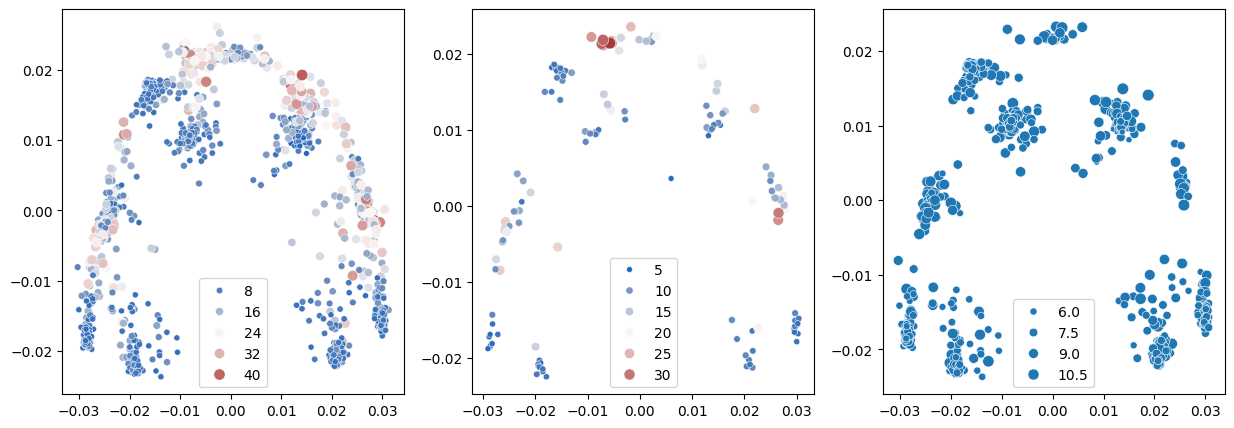

In [18]:
fig, axes = plt.subplots(1, 3, figsize = (15, 5))

color_palette = sns.color_palette('vlag', as_cmap = True)

sns.scatterplot(ax = axes[0], x = emb[:, 0], y = emb[:, 1], hue = rescale(rf.trust_scores), size = rescale(rf.trust_scores), palette = color_palette)
sns.scatterplot(ax = axes[1], x = emb[inds_test, 0], y = emb[inds_test, 1], hue = rescale(rf3.trust_scores_test), size = rescale(rf3.trust_scores_test), palette = color_palette)
sns.scatterplot(ax = axes[2], x = emb[trust_above_oob, 0], y = emb[trust_above_oob, 1], size = rescale(rf.trust_scores)[trust_above_oob], palette = color_palette)

# plt.scatter(emb[49, 0], emb[49, 1], s = 100, c = 'r', marker = 'x')
# plt.scatter(emb[72, 0], emb[72, 1], s = 100, c = 'g', marker = 'x')

In [19]:
trust_threshold_9 = rf.get_trust_threshold(0.9)
trust_threshold_5 = rf.get_trust_threshold(0.1)

diff_top_2_proba = rf.get_max_2_proba_diffs()

In [20]:
print(np.mean(rf.trust_scores[~rf.is_correct_oob]))

0.8241296993084803


In [21]:
print(np.mean(rf.trust_scores))

0.9255131061126235


In [22]:
rf.oob_score_

0.9340277777777778

In [23]:
np.sum(rf.prox_predict(x, oob_predict = True) == rf.oob_predictions) / len(y)

0.9972222222222222

In [24]:
print(np.mean(rf.trust_scores[rf.is_correct_oob]))
print(np.mean(rf.diff_top_2_proba[rf.is_correct_oob]))
print(np.mean(rf.trust_proba_diff[rf.is_correct_oob]))


0.932674015886894
0.7935856574327884
0.7793848941536029


In [25]:
print(np.mean(rf.trust_scores[~rf.is_correct_oob]))
print(np.mean(rf.diff_top_2_proba[~rf.is_correct_oob]))
print(np.mean(rf.trust_proba_diff[~rf.is_correct_oob]))

0.8241296993084803
0.3467546153967754
0.4760365954029604


In [26]:
print(np.sum(rf.oob_predictions[rf.trust_scores > rf.oob_score_] == y[rf.trust_scores > rf.oob_score_])/len(y[rf.trust_scores > rf.oob_score_]))

0.9966740576496674


In [27]:
print(np.sum(rf.oob_predictions[rf.trust_scores < rf.oob_score_] == y[rf.trust_scores < rf.oob_score_])/len(y[rf.trust_scores < rf.oob_score_]))

0.828996282527881


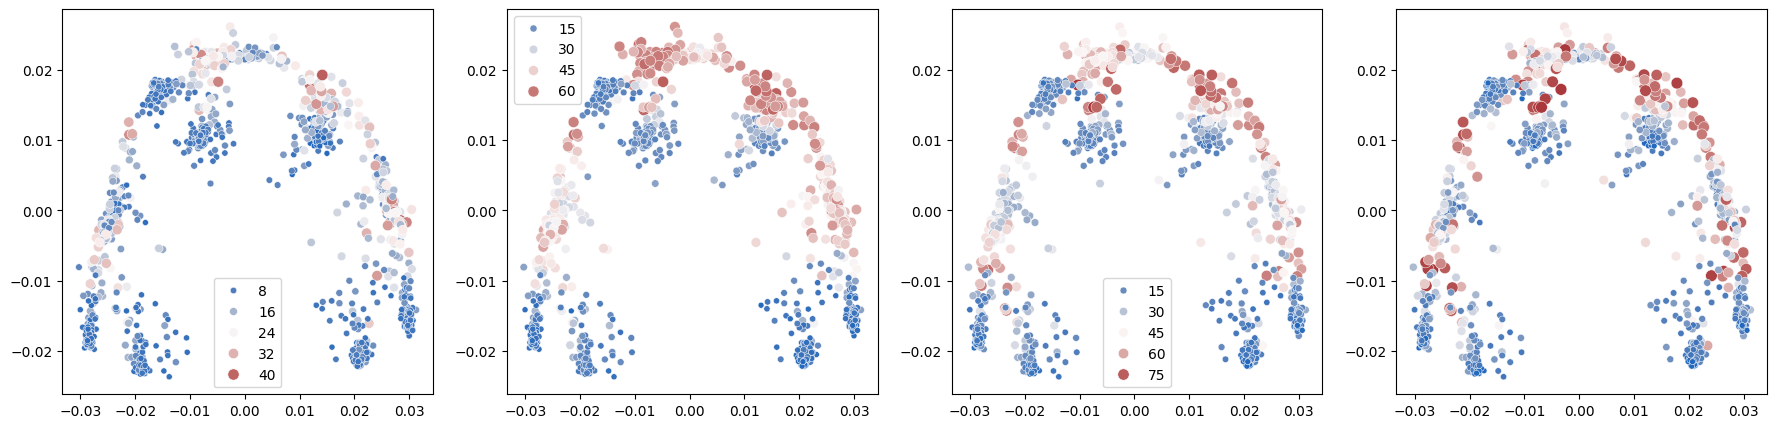

In [28]:
fig, axes = plt.subplots(1, 4, figsize = (22, 5))

sns.scatterplot(ax = axes[0], x = emb[:, 0], y = emb[:, 1], hue = rescale(rf.trust_scores), size = rescale(rf.trust_scores), palette = 'vlag')
sns.scatterplot(ax = axes[1], x = emb[:, 0], y = emb[:, 1], hue = rescale(trust_threshold_5), size = rescale(trust_threshold_5), palette = 'vlag')
sns.scatterplot(ax = axes[2], x = emb[:, 0], y = emb[:, 1], hue = rescale(rf.trust_proba_diff), size = rescale(rf.trust_proba_diff), palette = 'vlag')
sns.scatterplot(ax = axes[3], x = emb[:, 0], y = emb[:, 1], hue = rescale(rf.diff_top_2_proba), size = rescale(rf.diff_top_2_proba), palette = 'vlag')

axes[3].legend().remove()

In [29]:
rf3.oob_score_

0.9390432098765432

In [30]:
x['oob_correct'] = rf.is_correct_oob
x['diff_top_2_proba'] = rf.diff_top_2_proba
x['trust_proba_diff'] = rf.trust_proba_diff

In [31]:
x.groupby('oob_correct').mean()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V55,V56,V57,V58,V59,V60,trust,class,diff_top_2_proba,trust_proba_diff
oob_correct,,,,,,,,,,,,,,,,,,,,,
False,4.111226,6.145103,9.184926,10.162378,-1.131808,-1.137773,-3.882278,-4.141134,-1.076716,-1.339764,...,-0.169721,0.092535,0.508262,0.602407,1.201591,1.212394,0.824130,4.926316,0.346755,0.476037
True,-0.290384,-0.434041,-0.648749,-0.717789,0.079942,0.080363,0.274213,0.292496,0.076051,0.094630,...,0.011988,-0.006536,-0.035900,-0.042549,-0.084871,-0.085634,0.932674,4.336059,0.793586,0.779385


Mean:  0.8241296993084803
Std.:  0.06237594188090419
Mean:  0.932674015886894
Std.:  0.07144285413765522
Overall Mean:  0.9255131061126235
Overall Std.:  0.07585531659945587
OOB Score:  0.9340277777777778


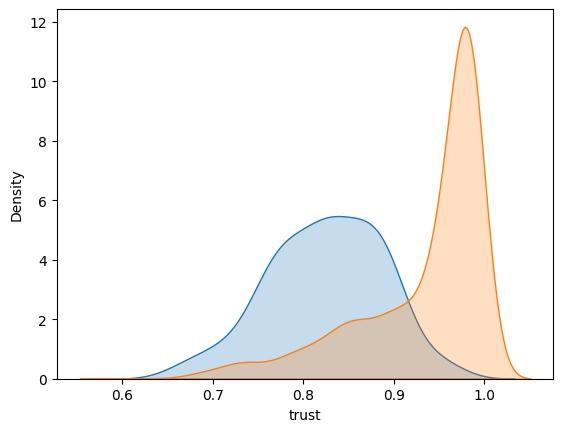

In [32]:
for group in x.groupby('oob_correct'):
    print('Mean: ', np.mean(group[1]['trust']))
    print('Std.: ', np.std(group[1]['trust']))
    sns.kdeplot(group[1]['trust'], fill = True)

print('Overall Mean: ', x['trust'].mean())
print('Overall Std.: ', x['trust'].std())
print('OOB Score: ', rf.oob_score_)

In [33]:
x_temp = x[x['trust'] > (x['trust'].mean() + x['trust'].std())].oob_correct
x_temp = x[x['trust'] > x['trust'].mean()].oob_correct

print(x_temp.mean())

0.9967602591792657


In [34]:
quantiles = np.quantile(x['trust'], np.linspace(0, .99, 100))
temp_oob_scores = []

for i in quantiles:
    x_temp = x[x['trust'] >= i].oob_correct
    # print(i, x_temp.mean())

    temp_oob_scores.append(x_temp.mean())

In [35]:
rf3.trust_quantiles

array([0.56318156, 0.67162244, 0.70585783, 0.73356795, 0.75140353,
       0.76515216, 0.77382619, 0.78472697, 0.79398482, 0.80368068,
       0.81174588, 0.81914257, 0.82490351, 0.83221142, 0.8371927 ,
       0.84257172, 0.84895507, 0.85399823, 0.85854991, 0.86239048,
       0.86667762, 0.87042863, 0.87563173, 0.88030306, 0.88441689,
       0.88852576, 0.89351847, 0.89715693, 0.89925603, 0.90321785,
       0.9072318 , 0.91206355, 0.91472939, 0.91898875, 0.92225028,
       0.92474611, 0.92936698, 0.9332166 , 0.9376298 , 0.94056553,
       0.94365952, 0.94590944, 0.94800446, 0.95032385, 0.95223758,
       0.95409879, 0.95667607, 0.95857478, 0.96016139, 0.96233384,
       0.96340535, 0.96452754, 0.96566379, 0.96667325, 0.96807126,
       0.96941953, 0.97051325, 0.97167553, 0.97279425, 0.97381557,
       0.97445682, 0.97566399, 0.97634437, 0.9771457 , 0.97785615,
       0.97898454, 0.97971073, 0.98041584, 0.98080712, 0.981776  ,
       0.98243597, 0.98319502, 0.98380537, 0.98445733, 0.98501

In [36]:
rf3.trust_quantiles_test

array([0.70114627, 0.73411741, 0.75132402, 0.76943538, 0.77074097,
       0.7794659 , 0.79766293, 0.80943282, 0.81533208, 0.81863598,
       0.82778896, 0.83858832, 0.84488009, 0.8513432 , 0.85566665,
       0.85810601, 0.86190482, 0.86716165, 0.87957402, 0.88483005,
       0.88599598, 0.88961426, 0.89001263, 0.89342198, 0.89468956,
       0.89752908, 0.90212985, 0.90856523, 0.91046937, 0.91132137,
       0.91826092, 0.92379029, 0.92532264, 0.92880715, 0.93556571,
       0.9395345 , 0.93959144, 0.94121959, 0.94249878, 0.94531364,
       0.94673458, 0.94811833, 0.9505297 , 0.95114498, 0.952373  ,
       0.95399796, 0.95641384, 0.95672522, 0.95808834, 0.95936689,
       0.96065795, 0.96148981, 0.96218454, 0.96384918, 0.96688233,
       0.96856285, 0.96943668, 0.97061036, 0.97105386, 0.97181628,
       0.97230809, 0.97319159, 0.97597438, 0.97642883, 0.97661912,
       0.97718601, 0.97766928, 0.97842613, 0.98033955, 0.98110831,
       0.98125666, 0.98162744, 0.98195349, 0.98279504, 0.98318

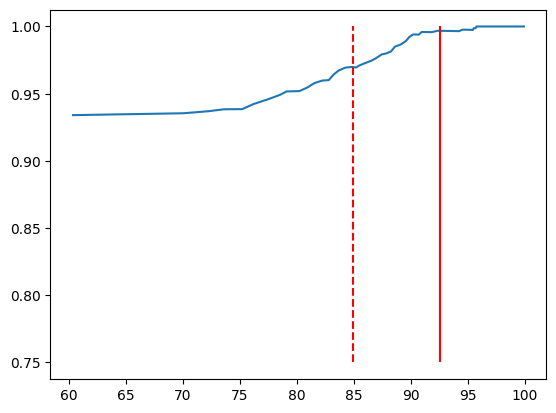

In [37]:
plt.plot(quantiles * 100, temp_oob_scores)
plt.vlines(x = x['trust'].mean() * 100, ymin = 0.75, ymax = 1, color = 'r')
plt.vlines(x = x['trust'].mean() * 100 - x['trust'].std() * 100, ymin = 0.75, ymax = 1, color = 'r', linestyles = 'dashed')

In [38]:
# For each quantile, get pct of points deemed "unclassifiable" that are correct vs incorrect, as well as just unclassifiable

test_trust_accuracy = []
pcts_correct = []
count_unclassifiable = []

quantiles_kept = []

for q in rf3.trust_quantiles:

    try:
        preds_temp = rf3.predict(x_test.iloc[test_trust_scores >= q, :])
        test_trust_accuracy.append(np.mean(preds_temp ==  y_test[test_trust_scores >= q]))
        count_unclassifiable.append(np.sum(test_trust_scores < q))

        quantiles_kept.append(q)

    except:
        print('Say no more')






Say no more


Text(0, 0.5, 'Number of Unclassifiable Points')

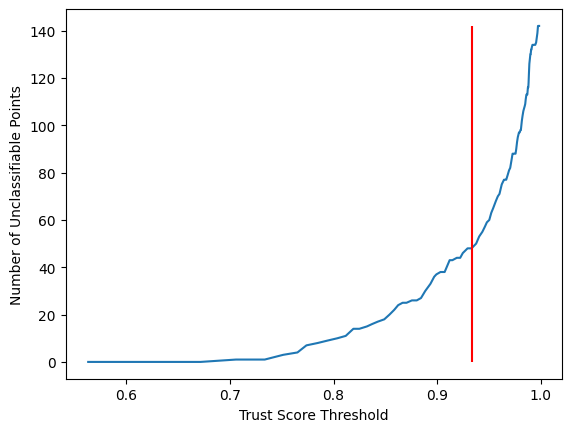

In [39]:
plt.plot(quantiles_kept, count_unclassifiable)
plt.vlines(x = np.mean(rf3.trust_scores_test), ymin = 0, ymax = np.max(count_unclassifiable), color = 'r')
plt.xlabel('Trust Score Threshold')
plt.ylabel('Number of Unclassifiable Points')

In [40]:
x[x['trust'] < 0.2]

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V56,V57,V58,V59,V60,trust,class,oob_correct,diff_top_2_proba,trust_proba_diff


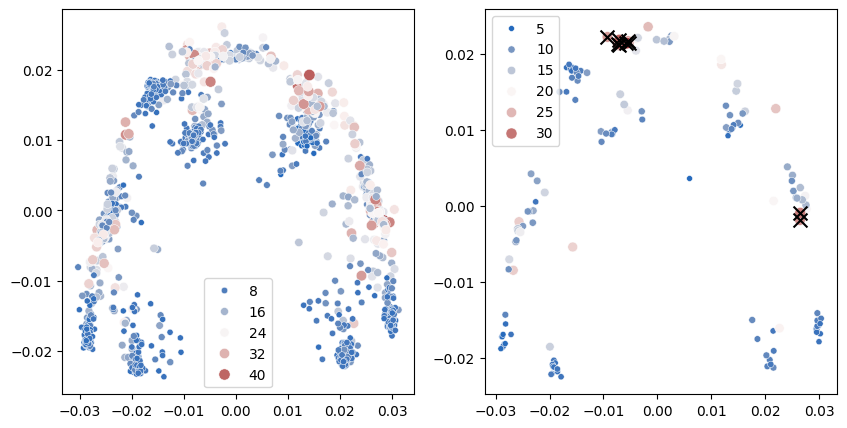

In [58]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))

color_palette = sns.color_palette('vlag', as_cmap = True)

sns.scatterplot(ax = axes[0], x = emb[:, 0], y = emb[:, 1], hue = rescale(rf.trust_scores), size = rescale(rf.trust_scores), palette = color_palette)
sns.scatterplot(ax = axes[1], x = emb[inds_test, 0], y = emb[inds_test, 1], hue = rescale(rf3.trust_scores_test), size = rescale(rf3.trust_scores_test), palette = color_palette)
# sns.scatterplot(ax = axes[2], x = emb[trust_above_oob, 0], y = emb[trust_above_oob, 1], size = rescale(rf.trust_scores)[trust_above_oob], palette = color_palette)
axes[1].scatter(emb[inds_test[test_trust_scores < 0.8], 0], emb[inds_test[test_trust_scores < 0.8], 1], s = 100, c = 'k', marker = 'x')


In [42]:
test_trust_scores < 0.2

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [43]:
# example = x.iloc[1778, :64].values
# plt.imshow(np.asarray(example, dtype = float).reshape((8, 8)))

Text(0, 0.5, 'Accuracy After Removing Unclassifiable Points')

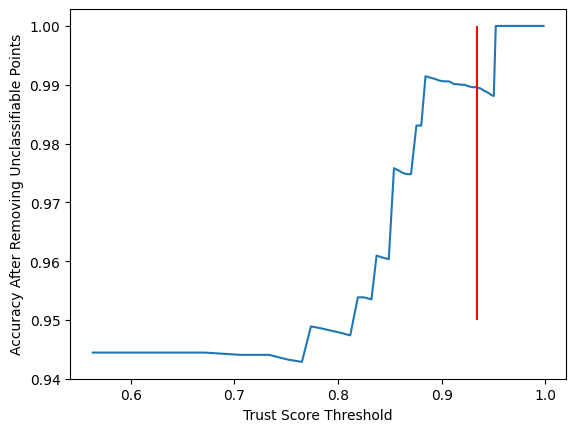

In [44]:
plt.plot(quantiles_kept, test_trust_accuracy)
plt.vlines(x = np.mean(rf3.trust_scores_test), ymin = 0.95, ymax = 1, color = 'r')
plt.xlabel('Trust Score Threshold')
plt.ylabel('Accuracy After Removing Unclassifiable Points')

In [45]:
# Set a threshold based on desired accuracy?

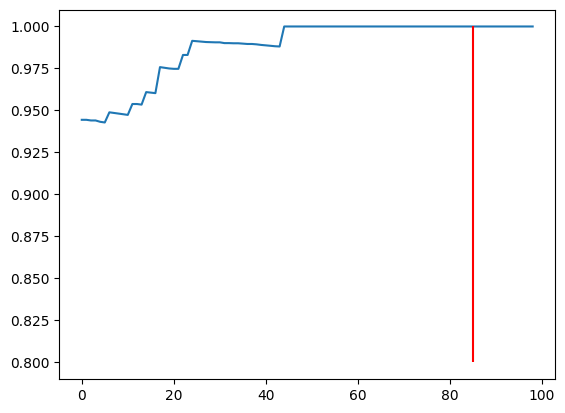

In [46]:
plt.plot(test_trust_accuracy)
plt.vlines(x['trust'].mean() * 100 - x['trust'].std() * 100, ymin = 0.8, ymax = 1, color = 'r')

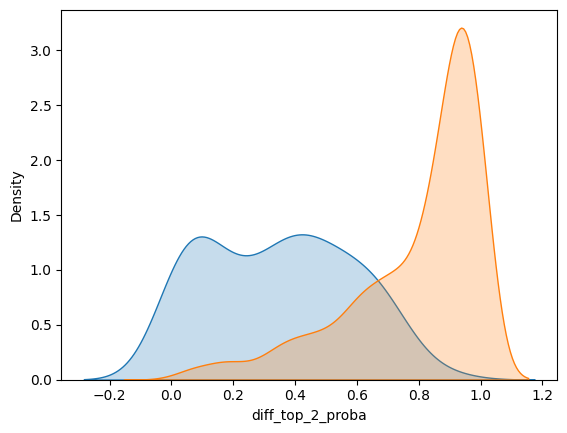

In [47]:
for group in x.groupby('oob_correct'):
    sns.kdeplot(group[1]['diff_top_2_proba'], fill = True)

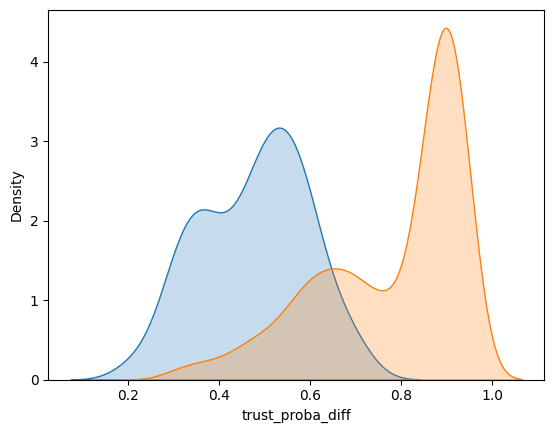

In [48]:
for group in x.groupby('oob_correct'):
    sns.kdeplot(group[1]['trust_proba_diff'], fill = True)

<Axes: xlabel='V1', ylabel='V2'>

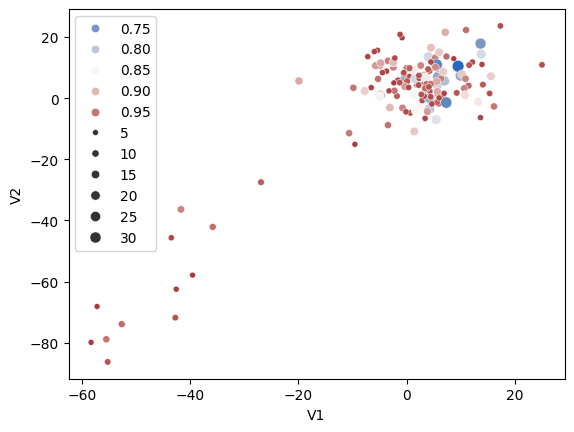

In [49]:
# sns.scatterplot(x = x.iloc[inds_test, 0], y = x.iloc[inds_test, 1], hue = y[inds_test], size = rescale(rf3.trust_scores_test), palette = 'Dark2')
sns.scatterplot(x = x.iloc[inds_test, 0], y = x.iloc[inds_test, 1], hue = rf3.trust_scores_test, size = rescale(rf3.trust_scores_test), palette = 'vlag')

<Axes: xlabel='V1', ylabel='V2'>

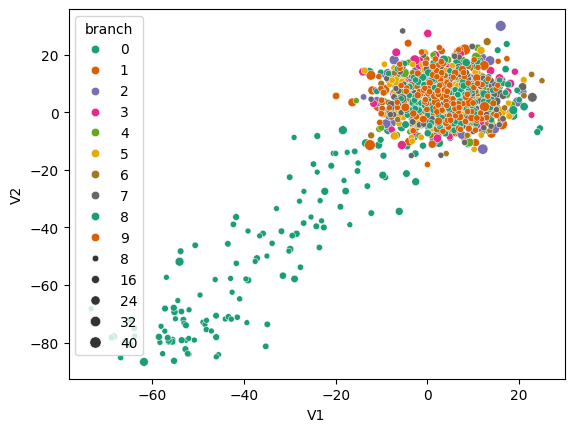

In [50]:
sns.scatterplot(x = x.iloc[:, 0], y = x.iloc[:, 1], hue = y, size = rescale(rf.trust_scores), palette = 'Dark2')

<Axes: xlabel='V1', ylabel='V2'>

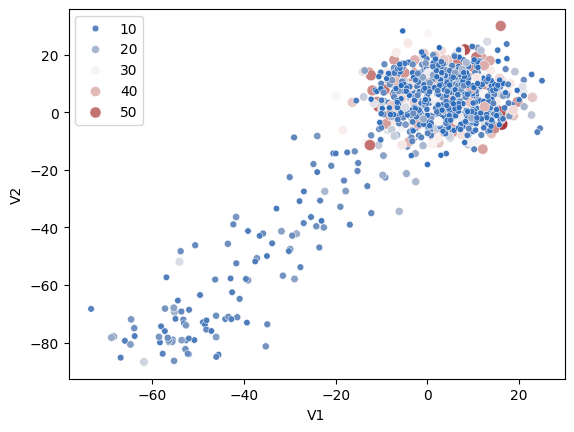

In [51]:
sns.scatterplot(x = x.iloc[:, 0], y = x.iloc[:, 1], hue = rescale(rf.trust_max_proba), size = rescale(rf.trust_max_proba), palette = 'vlag')

<Axes: xlabel='V1', ylabel='V2'>

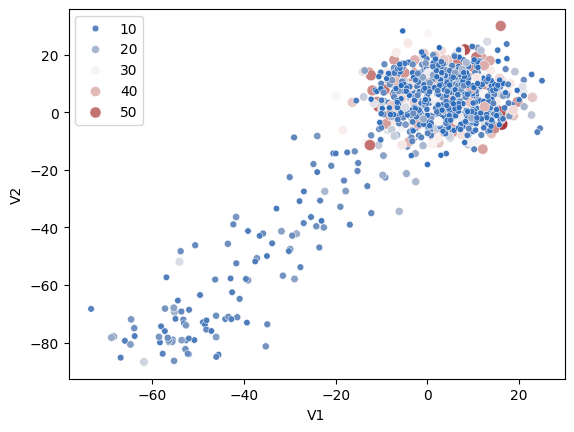

In [52]:
sns.scatterplot(x = x.iloc[:, 0], y = x.iloc[:, 1], hue = rescale(rf.trust_correct_proba), size = rescale(rf.trust_correct_proba), palette = 'vlag')

<Axes: xlabel='V1', ylabel='V2'>

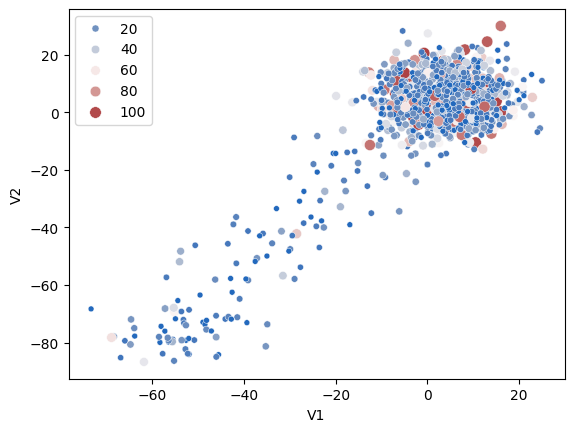

In [53]:
sns.scatterplot(x = x.iloc[:, 0], y = x.iloc[:, 1], hue = rescale(rf.diff_top_2_proba), size = rescale(rf.diff_top_2_proba), palette = 'vlag')

<Axes: xlabel='V1', ylabel='V2'>

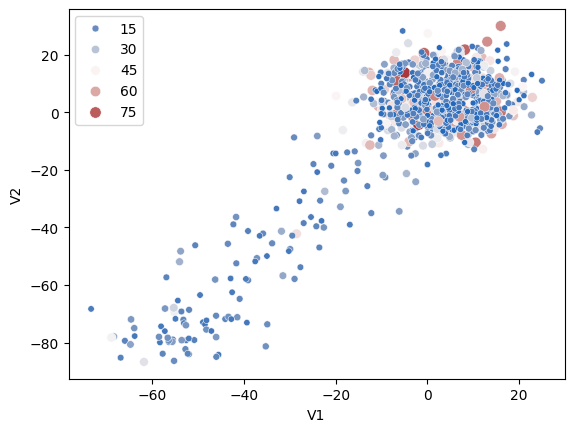

In [54]:
sns.scatterplot(x = x.iloc[:, 0], y = x.iloc[:, 1], hue = rescale(rf.trust_proba_diff), size = rescale(rf.trust_proba_diff), palette = 'vlag')

In [55]:

inds_test[np.argmin(rf3.trust_scores_test)]

277

In [56]:
inds_test[np.argmax(rf3.trust_scores_test)]

1080

In [57]:
# TODO: Experiment: make bivariate blobs, but put a point in the middle of the
# opposite blob class. Then, check if the trust score is low for that point under
# a few conditions: 1) with raw trust, 2) with raw trust multiplied by max proba
# 3) with raw trust mutliplied by correct proba.